In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
import os
from pathlib import Path

cwd = Path(os.getcwd())
train_data = cwd / 'Data' / 'TrainProcessed.csv'
test_data = cwd / 'Data' / 'TestProcessed.csv'

train_df = pd.read_csv(train_data,sep=',')
test_df = pd.read_csv(test_data,sep=',')

In [2]:
test_df = test_df[test_df['src_url'].isin(train_df['src_url'].values) == False]
test_df['Split'] = 'Test'
train_df['Split'] = 'Train'

In [3]:
df = pd.concat([test_df, train_df], axis=0)
df.reset_index(inplace=True)

# Cleaning Data

We'll do another pass-through to clean the text up a bit.

Note that most of these regular-expressions were found by a mixture of manual inspection and trial-and-error using the code chunks contained below (i.e. word clouds, etc)

In [4]:
# A number of regex terms to remove known noisey elements (i.e. from markdown, etc)
df['Text'].replace(to_replace=r'\[[^\n]*\]',value=' ',regex=True, inplace=True)
df['Text'].replace(to_replace=r'\\\* [\w]* \*\\',value=' ',regex=True, inplace=True)
df['Text'].replace(to_replace=r'\/\* [\w]* \*\/',value=' ',regex=True, inplace=True)
df['Text'].replace(to_replace=r'.[\w]* ',value=' ',regex=True, inplace=True)
df['Text'].replace(to_replace=r'\\ [\w ]* ',value=' ',regex=True, inplace=True)
df['Text'].replace(to_replace='\_', value=' ',regex=True, inplace=True)
df['Text'].replace(to_replace='font', value=' ', regex=True, inplace=True)
df['Text'].replace(to_replace=r'pdf', value=' ', regex=True, inplace=True)
df['Text'].replace(to_replace=r'PDF', value='', regex=True, inplace=True)
df['Text'].replace(to_replace=r'Â', value=' ', regex=True, inplace=True)
df['Text'].replace(to_replace=r'â', value=' ', regex=True, inplace=True)
df['Text'].replace(to_replace=r'[^\w]z[^\w]', value=' ', regex=True ,inplace=True)
df['Text'].replace(to_replace=r'[^\w]Z[^\w]', value=' ', regex=True, inplace=True)

In [5]:
num_duplicates = len(df)-len(df.drop_duplicates(subset=["src_url"]))
if num_duplicates == 0:
    print("No duplicates")
else:
    print(f"{num_duplicates} duplicates found.")

No duplicates


In [6]:
df.dropna(subset=['Text'],inplace=True)
corpus = df['Text']

vectorizer = CountVectorizer(strip_accents='unicode',ngram_range=(1,2))

X = vectorizer.fit_transform(corpus)
dtm = pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names())

dtm = dtm[[i for i in dtm.columns if i.isalpha()]]
dtm = dtm[dtm.columns[dtm.sum() >= 5]]
print(dtm.shape[1])

pca = PCA(n_components=0.99, svd_solver='full')
princ_comps = pca.fit_transform(dtm)
dtm = pd.DataFrame(data=princ_comps)
print(dtm.shape[1])

8329
204


In [7]:
distortions = []
kvals = range(1,25)
for k in kvals:
    model = KMeans(n_clusters=k).fit(dtm)
    model.fit(dtm)
    distortions.append(sum(np.min(cdist(dtm, model.cluster_centers_, 'euclidean'), axis=1)) / dtm.shape[0])

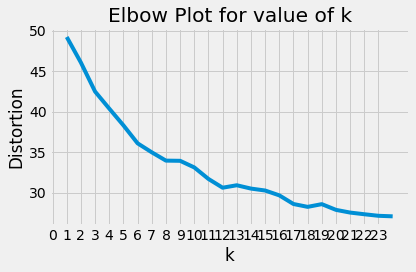

In [8]:
# Plot the elbow
plt.plot(kvals, distortions)
plt.xticks(np.arange(0, max(kvals), 1))
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Plot for value of k')
plt.tight_layout()
plt.savefig('kmeans_elbow.png')

In [9]:
dtm.reset_index(inplace=True)
df.reset_index(inplace=True)

In [10]:
gm = GaussianMixture(n_components=11, random_state=0).fit(dtm)
predictions = gm.predict(dtm)

cluster_labels = []
for i in range (11):
    cluster_inds = np.where(predictions == i)
    cluster_df = df.loc[cluster_inds]
    cluster_df = cluster_df.loc[cluster_df["sub"] == "UnearthedArcana"]
    print(f"Cluster # {i}")
    print(cluster_df['flair'].value_counts())

Cluster # 0
Subclass      74
Class         26
Race           7
Monster        7
Official       7
Item           7
Spell          5
Mechanic       3
Compendium     2
Feature        2
Feat           2
Name: flair, dtype: int64
Cluster # 1
Subclass      63
Race          26
Item          25
Monster       16
Spell         14
Class         14
Compendium     4
Mechanic       4
Feat           4
Feature        1
Name: flair, dtype: int64
Cluster # 2
Subclass      71
Class         22
Race          14
Spell         12
Monster       10
Mechanic       7
Item           5
Feat           5
Compendium     4
Official       2
Feature        2
Other          2
Background     1
Name: flair, dtype: int64
Cluster # 3
Subclass      30
Class          7
Spell          5
Monster        4
Race           4
Item           4
Compendium     3
Feat           3
Background     1
Mechanic       1
Name: flair, dtype: int64
Cluster # 4
Compendium    1
Name: flair, dtype: int64
Cluster # 5
Subclass      36
Class         34
